# 1. 사전 세팅

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 1.1. Github 상에서 Invalid Notebook 오류가 발생할 때

In [ ]:
%cd "/content/drive/MyDrive/데이터 분석/projects/ML_protfoilo/1. 의류 판매량 예측 모델링"

!jupyter nbconvert \
  --ClearMetadataPreprocessor.enabled=True \
  --ClearOutputPreprocessor.enabled=True \
  --to notebook --inplace "1. 의류 판매량 예측 모델링.ipynb"

## 1.2. 기본 세팅

In [ ]:
%cd "/content/drive/MyDrive/데이터 분석/projects/ML_protfoilo/1. 의류 판매량 예측 모델링"

import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설치
# 실행 후에는 세션 다시 시작하기
!sudo apt-get install -y fonts-nanum -qq
!sudo fc-cache -f
!rm -rf ~/.cache/matplotlib

# !gdown --folder "data_link" --remaining-ok

In [ ]:
!pwd

# 2. 문제 정의


---

    A 의류 회사에서 생산량을 조절하기 위해 판매량을 예측하려고 한다.
    의류 종류에 따라 계절성을 타기 때문에, 이런 특징을 고려할 수 있는 모델링이 필요하다.



## 2.1. 도메인 지식

---

▸ 티셔츠 제조의 Lead Time(주문부터 납품까지 걸리는 전체 시간)

    티셔츠 발주를 넣어 생산하는 데 통상 2~3주가 걸린다.
    그러나, 보통 베트남이나 중국 등의 해외에서의 생산을 주로 하기 때문에 유통 시간까지 고려해서 계산해야 한다.
    배에 싣거나, 검사하거나, 이동하는 시간까지 고려하게 되면 총 8주 정도가 걸린다고 예상한다.

▸ 재고 비용

    재고를 가지고 있을 때 발생하는 비용으로, 재고가 생기면 창고에 적재되어야 하므로 창고 사용료, 운영료 등을 줄이는 것을 목적으로 해야 한다.
    그렇기에 생산량을 조절해 재고를 최소화하는 것이 매우 중요하다.

▸ MD의 역할

    MD가 작년 판매량과 회사의 기대치(의지치)를 반영해 발주를 하게 된다.
    이를 정할 때에는 오직 MD의 감으로 Baseline + α을 잡게 된다.
    
▸ Demand Plan(수요 계획)

    보통 한 번에 몇 만 장을 발주하는 것이 아니라, 나눠서 발주를 하게 된다.
    이때 사고가 나는 경우가 많은데, 적게 주문했을 때 재고가 부족한 점, 사람들이 트렌드가 바뀌어 사지 않는 점 등이 드러날 수 있다.

▸ 트렌드의 변화

    옷차림 트렌드는 날씨에 따라 가장 빈번하게 바뀌고, 대형 포털의 검색어에 따라서도 바뀔 수 있다.

▸ 번외) 공장에서 생성되는 시계열 데이터의 경우

    닫혀있는 데이터이기 때문에 외부 요인을 크게 신경쓰지 않아도 되지만, 판매 데이터의 경우에는 검색어 트렌드와 같은 외부 요인도 신경써주면 좋다.

# 3. 데이터 확인

## 3.1. 데이터 명세

---

    데이터는 종류/날짜별로 한 행씩 구분되어 총 500개 가량의 서로 다른 티셔츠가 제공되어 있다.

| Column | Description |
|:----|:----|
| SEASON | SS(Spring/Summer) or AW(Autumn/Winter) |
| Type | 국내, 해외 등 |
| ... | 날짜 등 |

## 3.2. 데이터 살펴보기

In [ ]:
%cd "/content/drive/MyDrive/데이터 분석/projects/ML_protfoilo/1. 의류 판매량 예측 모델링"
!ls

In [ ]:
# pytorch-forecasting: PyTorch DeepAR
# MXNet 기반의 호환 문제로 Lightning 기반 DeepAR로 진행
# !pip install pytorch-forecasting==1.5.0 pytorch-lightning==2.4.0 --quiet

# 위 Lighting 기반 DeepAR도 호환 문제로... darts로 진행해보게씀...

In [ ]:
import pandas as pd

# Default가 max_columns은 20, max_rows는 60이니까 늘려서 안 짤리게 하기
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

df = pd.read_excel('Data/WEAR_TS_ALL.xlsx')
df.head()

    티셔츠마다 판매 시작 일자가 다름을 확인했다.
    각각의 SKU(재고 관리 단위)에 대한 예측을 하게 되면 시간도 오래 걸리고, 데이터의 양도 적어 비효율적이다.
    그렇기에 이들을 따로 보는 것이 아닌 하나로 합쳐 분석할 것이다.


▸ 왜도와 첨도

    왜도(7일 동안의 평균의 왜도)를 확인하면 현재 판매량의 트렌드를 확인할 수 있다.
    첨도가 높게 되면 쏠림 현상이 일어나기 때문에, 특정 이벤트가 있었음을 짐작할 수 있다.

In [ ]:
# 515개의 제품군(SKU;Stock Keeping Unit)에 대해 1463개의 행을 보유
df.shape

## 3.3. 데이터 가공 명세

---

| 명세 | 내용 |
|:----|:----|
| 가공 범위 | <input type="checkbox" checked> Feature(Column) 변형<br> <input type="checkbox">기간 단위 데이터 분석 및 Big Volume 특성을 반영하기 위한 데이터 증강<br> <input type="checkbox" checked>다양한 Table을 참조하기 위한 데이터 분할|
| 가공 상세 | <b>Feature(Column) 변형</b><br><br>- 열로 구성되어 있는 날짜 정보를 Transpose하여 행으로 변환<br>- 단변량 데이터에서 정보 취득을 위해(Random Forest 구축을 위해) 각종 통계량으로 변환<br><br><b>데이터 분할</b><br><br>- 검증을 위해 학습 95%, 검증 5%로 분할 |
| 가공 결과 | <b>As is</b><br><br>- row: 515 / column: 1463 / table: 1<br><br> <b>To be(1)</b><br><br>- row: 1461(+946) / column: 1(-1462) / table: 1<br><br> <b>To be(2)</b><br><br>- row: 1308(-153) / column: 15(+14) / table: 1  |

# 4. 문제 해결 프로세스 정의

▸ 문제

    A 회사에서 재고에 대한 걱정이 늘어나고 있다.
    판매량을 알 수 있다면 재고 비용을 비약적으로 줄일 수 있을 것으로 기대하고 있다.
    
▸ 기대 효과

    의류 시장에서의 큰 비용 중에 하나는 재고 비용이다. 적정 생산량을 통해 재고 비용을 줄일 수 있다.

▸ 해결 방안

    시계열 예측과 Random Forest를 통한 판매량 예측
    시계열 분석을 위해서는 데이터를 단변량 데이터로 변환해야 한다.
    Random Forest를 위해서는 다변량 데이터로 변환해야 한다.

▸ 성과 측정

    실제 판매량과 예측량의 차이

▸ 현업 적용

    시계열 특성을 가진 데이터(보통 세상 모든 데이터는 시계열)를 만났을 때, 접근할 수 있는 방법 체득

# 5. 데이터 전처리 및 EDA

## 5.1. 데이터 전처리

In [ ]:
# 필요한 패키지 Import
import os
from pathlib import Path

import matplotlib.pyplot as plt
# numpy와의 호환 문제(np.bool 삭제)로 mxnet import 불가
# import mxnet as mx
import numpy as np
import pandas as pd
from matplotlib import rc
from matplotlib.dates import date2num

rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# mx.random.seed(0)
np.random.seed(0)

In [ ]:
df = pd.read_excel('Data/WEAR_TS_ALL.xlsx')
df

In [ ]:
# 20년도 데이터의 부족 문제로 20년 데이터는 제외 예정
len(df[df['SEASON'] == '20SS'])

In [ ]:
df.info()

In [ ]:
df.dtypes

In [ ]:
# 국내와 해외는 특성 차이로 인해 동시에 모델링 불가하기에 국내 데이터만 필터링
df = df[df['TYPE'] == '국내']
df.drop('TYPE', axis=1, inplace=True)

# 시즌별 판매량 예측이 목적이기 때문에 Season별로 group by하여 합계 생성
df = df.groupby('SEASON').sum()
df

In [ ]:
# 날짜별 판매량을 행으로 다루기 위한 전치
df = df.T

# 현재 Index가 날짜형 Index가 아니기 때문에 날짜형으로 변경
df.index = pd.to_datetime(df.index)
df

In [ ]:
df.index

In [ ]:
# 하나의 열로 병합
df = pd.concat([
    df[df.index.year == 2016]['16SS'],
    df[df.index.year == 2017]['17SS'],
    df[df.index.year == 2018]['18SS'],
    df[df.index.year == 2019]['19SS']
])

df = pd.DataFrame(df, columns=['sales'])
df

In [ ]:
df.plot(figsize=(20, 7))
plt.show()

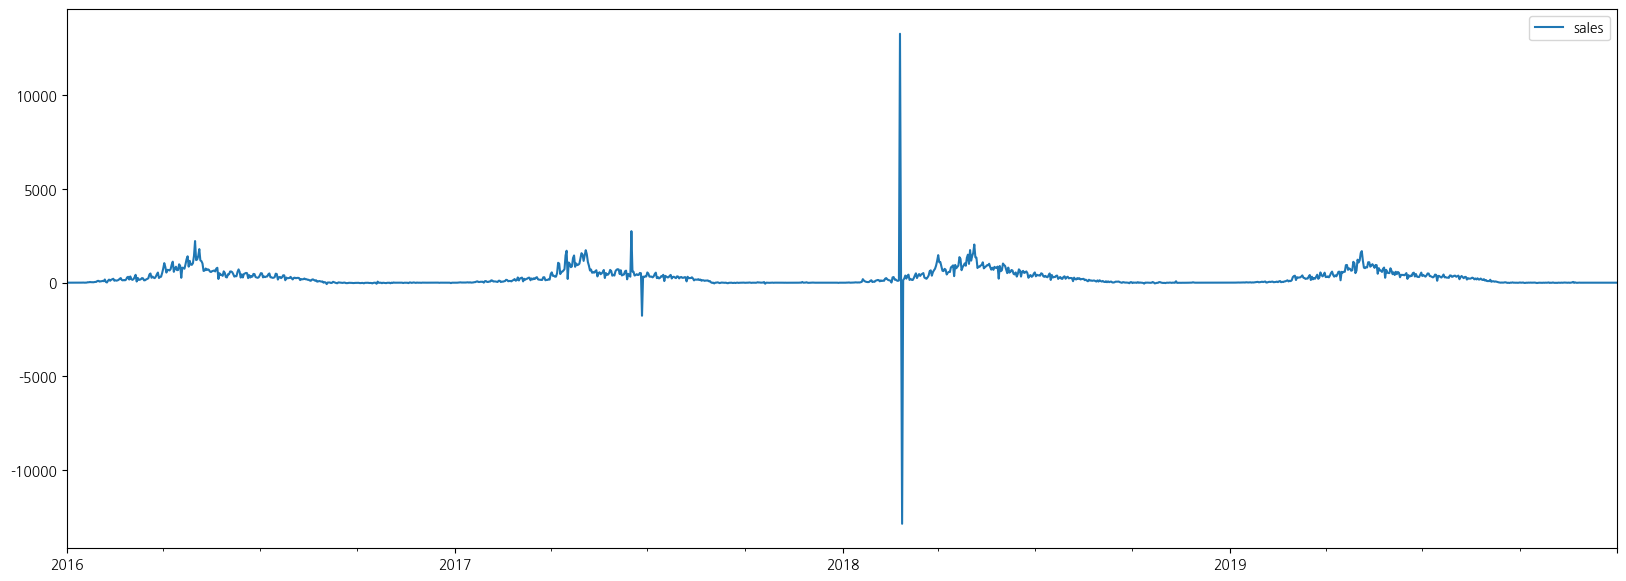

    이상치가 있음을 확인했다.
    그리고 마이너스가 찍힐 수는 있지만(환불로 인한), 2017년 중반부와 같은 마이너스는 말이 되지 않는다.
    중국 큰 손들(?)의 장난질일 수 있음 - 도메인 지식을 갖춘 이들과의 인터뷰가 이래서 중요하다.

In [ ]:
# 시스템 오류로 인한 Outlier 삭제를 위해 값을 치환
df[(df['sales'] < -1000) | (df['sales'] > 2500)] = 0

In [ ]:
df.plot(figsize=(20, 7))
plt.show()

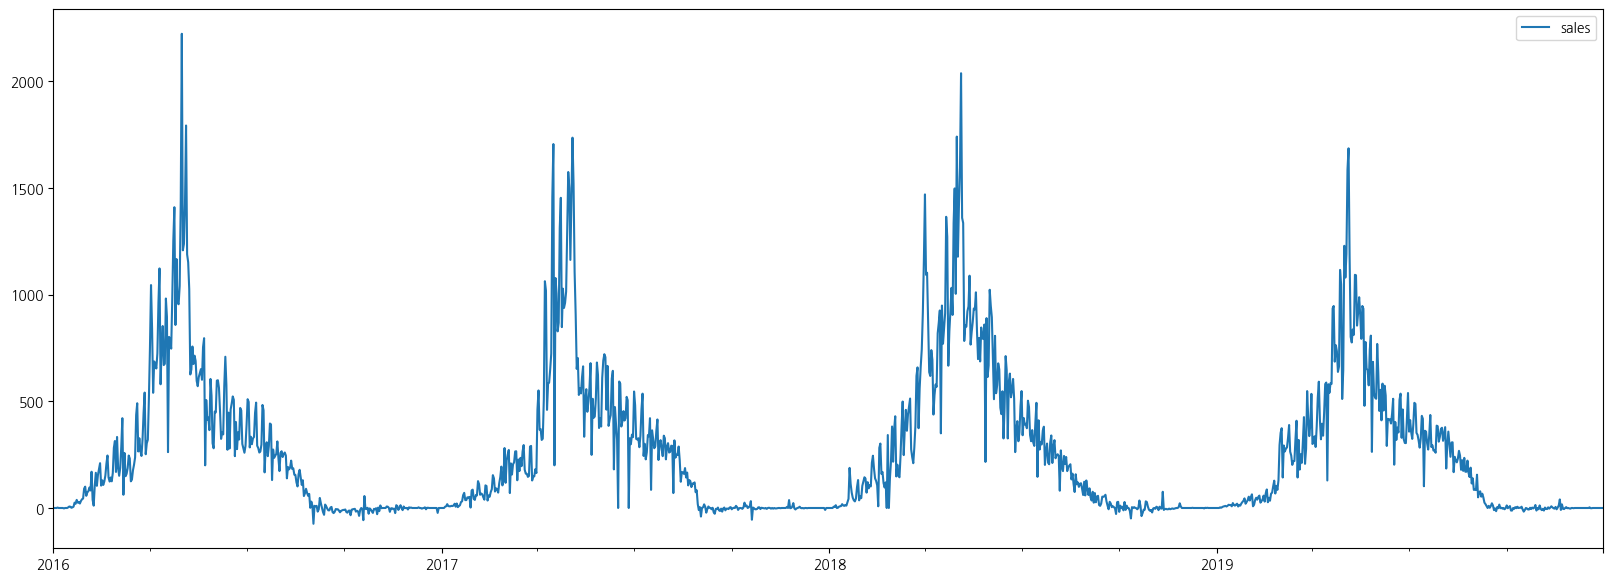

    특이점들의 대한 분석과 의문이 들어야 데이터를 해석할 수 있다.
    
    보통 확 증가하는 부분에서는 프로모션이 진행했음을 알 수 있고,
    보통 확 감소하는 부분에서 재고 비용이 많이 발생하게 된다.


In [ ]:
# 학습 데이터는 2019년 여름 시즌 이전까지
train_df = df[:-200]

# test 데이터는 2019년 여름 시즌부터 겨울 시즌 전까지 Peak 100일에 대한 예측
test_df = df[-200:-100]

In [ ]:
train_df.plot(figsize=(20, 7))
plt.show()

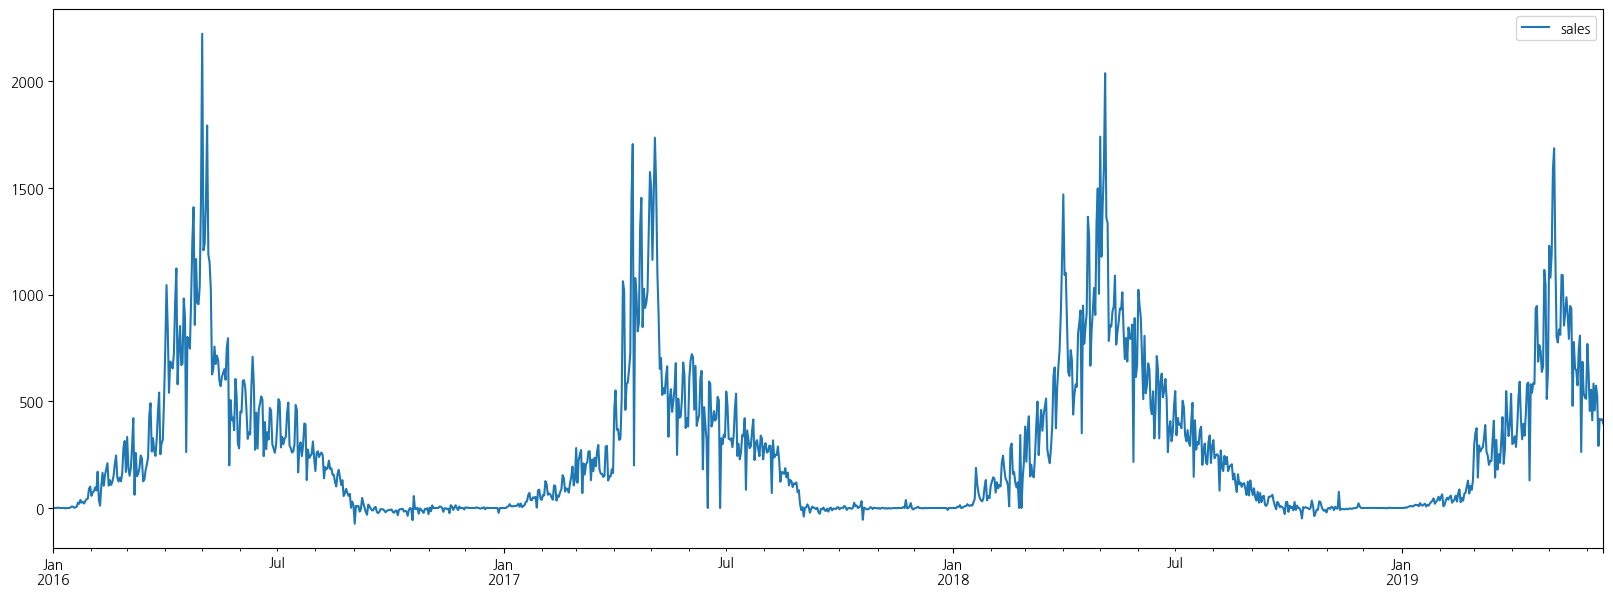

In [ ]:
test_df.plot(figsize=(20, 7))
plt.show()

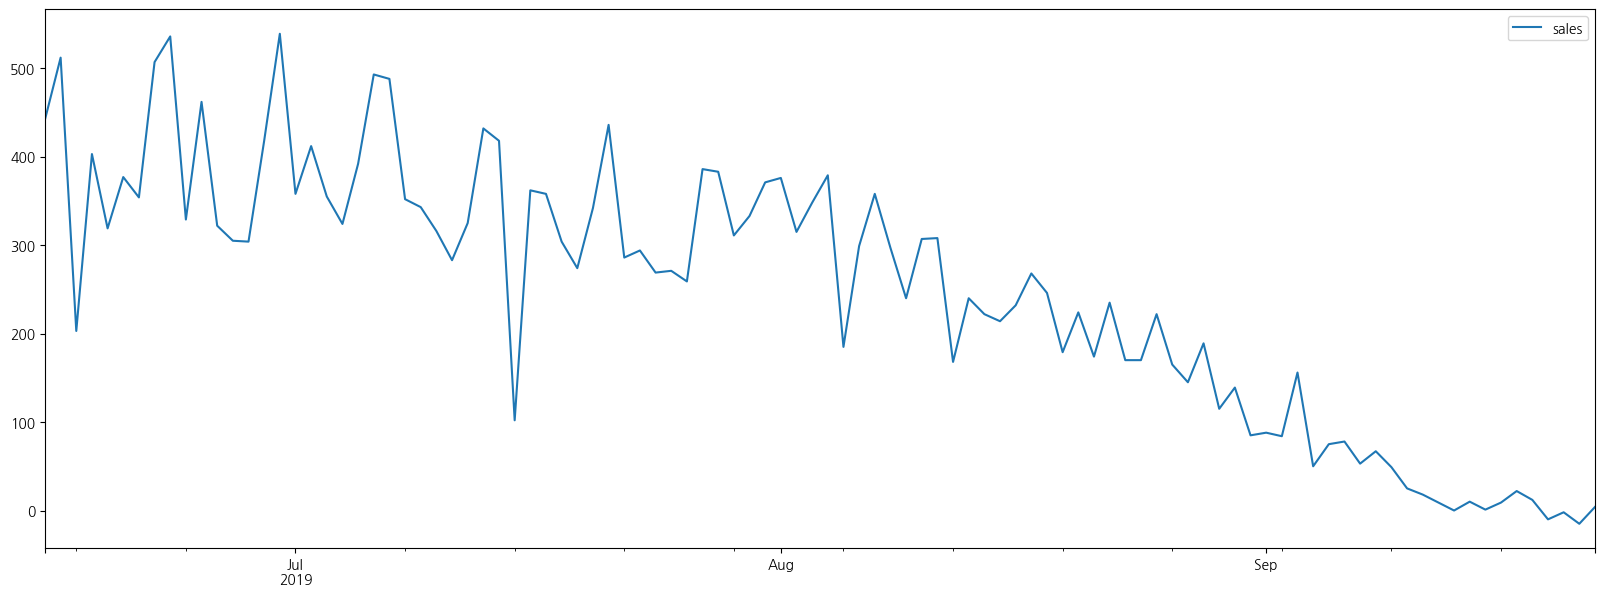

    판매량이 확 떨어지는 구간에 대해 예측을 해야 그 구간에서 더 이상 생산하지 않는다.
    그래서 6월의 판매량을 예측하게 되면, 그 8주 전인 4월의 발주량을 결정할 수 있게 된다.

# 6. 시계열 예측 모델링

## 6.1. glounts를 이용한 방법 (호환 X)

In [ ]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from pathlib import Path

'''
ts_entry: 실제 데이터
forecast_entry: 예측 데이터
'''
def plot_prob_forecasts(ts_entry, forecast_entry):
    prediction_intervals = (90.0, 50.0)
    legend = ['sales', 'observations', 'median prediction'] + [f'{k}% prediction interval' for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(20, 7))

    ts_entry.plot(ax=ax)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which='both')
    plt.legend(legend, loc='upper left')
    plt.show()

# DeepAR 알고리즘을 사용하기 위해 df를 ListDataset으로 재생성
train_ds = ListDataset([{FieldName.TARGET: train_df.values.flatten(),
                         FieldName.START: pd.Timestamp("2016-01-01 00:00:00", freq='D')
                        }],
                       freq='D')

test_ds = ListDataset([{FieldName.TARGET: test_df.values.flatten(),
                         FieldName.START: pd.Timestamp("2019-06-15 00:00:00", freq='D')
                        }],
                       freq='D')

# 시계열 예측 알고리즘 중 가장 많이 사용되고 있는 DeepAR(AutoRegression) 사용
estimator = DeepAREstimator(
    # 데이터 주기(D, W, M, Y)
    freq='D',
    # Trainer, cpu | gpu, 학습 반복 횟수
    trainer=Trainer(ctx='cpu', epochs=30, learning_rate=1E-3, hybridize=True, num_batches_per_epoch=30,),
    # layer 수
    num_layers=4,
    # lstm 셀 개수
    num_cells=40,
    context_length=30,
    cell_type='lstm' # gru도 가능
    # 얼마 기간에 대해 예측할 것인가?
    prediction_length=30
)

predictor = estimator.train(train_ds)

## 6.2. darts 기반 RNNModel을 이용한 방법

---

▸ GluonTS

    DeepAR의 원조지만, MXNet에 의존해서 환경 호환성 문제가 자주 일어나곤 한다... 내 환경에서도 마찬가지...


▸ u8darts (a.k.a. Darts)

    시계열 전용 파이썬 라이브러리로, 전통 모델부터 딥러닝 모델까지 단일 API로 학습/예측을 수행할 수 있다.
    TimeSeriess라는 고유 자료구조를 중심으로 likelihood, 공변량 등을 일관되게 다룬다.

▸ pytorch_lightning

    PyTorch의 학습 과정을 모듈화해서 훈련 보일러플레이트를 최소화하는 프레임워크다.
    Darts의 딥러닝 모델(RNNModel 등)은 내부적으로 Lightning을 사용해서 학습과 멀티 GPU 등을 활용할 수 있다.

In [ ]:
!pip install u8darts pytorch_lightning --quiet

In [ ]:
'''
TimeSeries: 시계열의 값(y) + 시계열 인덱스(time index)를 함께 보관하는 자료구조 / 공변량을 자연스레 붙일 수 있음.
RNNModel: RNN/LSTM/GRU 기반 예측 모델
datetime_attribute_timeseries: 요일, 월, 분기, 연중일, 주차 등 시간 속성 인코딩을 TimeSeries로 만들어주는 생성기
Scaler: 표준화 및 정규화 변환기(sklearn의 MinMax나 Standard Scaler 느낌을 Darts의 TimeSeries에 맞춘 버전)
GaussianLikelihood: 우도 / 평균과 표준편차를 함께 추정해서 예측 분포를 모델링해주는 모델
'''
from darts import TimeSeries
from darts.models import RNNModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.utils.likelihood_models import GaussianLikelihood
from darts.metrics import smape, mae, mse

In [ ]:
# Darts 모델에 넣기 위한 TimeSeries로의 변환 작업
series_train = TimeSeries.from_series(
    pd.Series(train_df.values.flatten(),
              index=pd.date_range("2016-01-01", periods=len(train_df), freq="D"),
              name="sales")
)

train_end = series_train.end_time()

series_test = TimeSeries.from_series(
    pd.Series(
        test_df.values.flatten(),
        index=pd.date_range(train_end + series_train.freq, periods=len(test_df), freq="D"),
        name="sales"
    )
)

In [ ]:
# 스케일링; 기본값은 표준화 방식 적용 ! 평균 0, 표준편차 1 되도록
scaler = Scaler()

# 훈련 데이터로만 fit()하기
series_train_scaled = scaler.fit_transform(series_train)
series_test_scaled  = scaler.transform(series_test)

In [ ]:
CONTEXT = 60
HORIZON = 30    # 마지막 30일 예측
TRAINING_LENGTH = 100

# 모델 정의
model = RNNModel(
    model="LSTM",                               # RNN 구조 선택하기
    input_chunk_length=CONTEXT,                 # 과거 30일을 입력으로 사용하기 !
    training_length=TRAINING_LENGTH,            # 슬라이딩 윈도우 길이 (90일)
    hidden_dim=64,                              # 은닉층 차원
    n_rnn_layers=3,                             # RNN 층 수
    dropout=0.2,
    batch_size=32,
    n_epochs=30,                                # = epochs
    optimizer_kwargs={"lr": 1e-3},
    random_state=42,
    likelihood=GaussianLikelihood(),            # 확률적 예측 활성화 (샘플 기반)
    pl_trainer_kwargs={"accelerator": "cpu"},   # Colab에서 GPU 환경이면 "gpu" 로
)

In [ ]:
# 모델 학습
model.fit(series_train_scaled, verbose=True)

```
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | V               | Linear           | 130    | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.671     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode

Epoch 29: 100%
 37/37 [00:07<00:00,  4.82it/s, train_loss=-2.45]

RNNModel(model=LSTM, hidden_dim=64, n_rnn_layers=3,
         dropout=0.2, training_length=100,
         input_chunk_length=60, batch_size=32, n_epochs=30,
         optimizer_kwargs={'lr': 0.001}, random_state=42,
         likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, beta_nll=0.0, prior_strength=1.0),
         pl_trainer_kwargs={'accelerator': 'cpu'})
```



In [ ]:
# train + test의 처음 70일을 합쳐서 context로 사용해서
# 그 다음 30일 예측해보기
series_context = series_train.concatenate(series_test[:-30])
series_context_scaled = scaler.transform(series_context)

# 마지막 30일 예측
# Darts는 likelihood=GaussianLikelihood()로 설정되어 있어서 한 시점마다 평균과 분산을 출력해줌
# 해당 분포에서 1000개의 샘플을 뽑아 예측 경로를 여러 개 생성하는 방식

# pred_scaled는 1000개 예측 시계열 샘플을 담은 확률적 TimeSeries 객체
pred_scaled = model.predict(n=HORIZON, series=series_context_scaled, num_samples=1000)
pred = scaler.inverse_transform(pred_scaled)

In [ ]:
# 평가 (test의 마지막 30일)
y_true = series_test[-30:]
y_pred = pred

print("MSE:", mse(y_true, y_pred))
print("MAE:", mae(y_true, y_pred))
print("sMAPE:", smape(y_true, pred))

```
MSE: 1345.3581288686973
MAE: 33.98139632577222
sMAPE: 80.09866026317522
```

    MSE가 1345...? 루트 씌우면 36 정도...
    36개 정도의 오차가 발생한다는 것인데.. 모델이 적합한 게 맞는가 싶다.



In [ ]:
# 시각화
plt.figure(figsize=(20, 7))
ax = plt.gca()

# test 전체 데이터 플롯
series_test.plot(ax=ax, label='Sales / Observations', color='tab:blue', lw=2)

# 예측 구간 추가 (마지막 30일만)
median = pred.quantile(0.5)
q05 = pred.quantile(0.05)
q25 = pred.quantile(0.25)
q75 = pred.quantile(0.75)
q95 = pred.quantile(0.95)

ax.fill_between(q05.time_index, q05.values().flatten(), q95.values().flatten(),
                color="#4CAF50", alpha=0.1, label="90.0% prediction interval")
ax.fill_between(q25.time_index, q25.values().flatten(), q75.values().flatten(),
                color="#81C784", alpha=0.3, label="50.0% prediction interval")

median.plot(ax=ax, label="median prediction", color="green", lw=2)

plt.title("Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True, which="both")
plt.legend(loc="upper left")
plt.show()

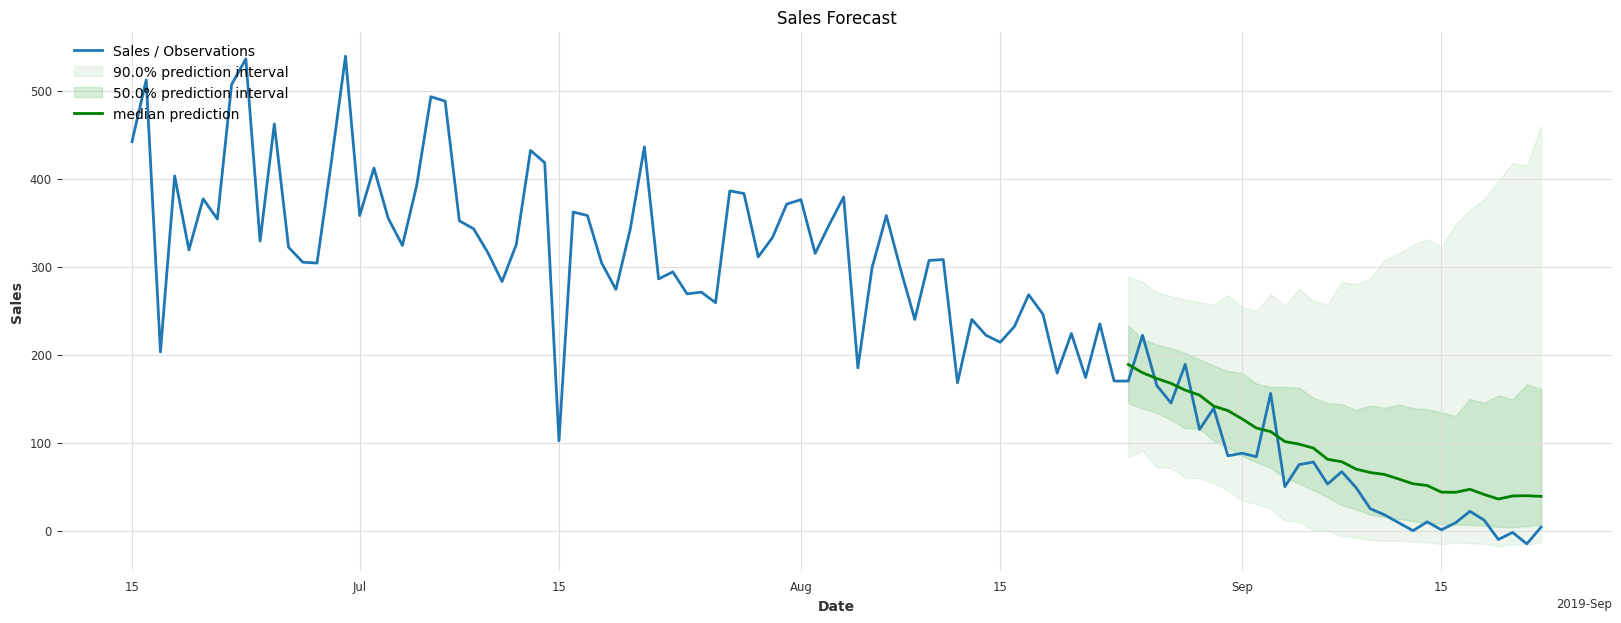

# 7. RandomForest 활용 모델링

## 7.1. RandomForestRegressor를 위해 데이터 변환

In [ ]:
'''
linregress: 간단한 선형 모델을 만들어 기울기를 가져가게 하기 위함
'''

from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    return slope

'''
test_labels: 실제 정답 레이블
'''
def evaluate(model, X_test, y_test):
    pred = model.predict(X_test)
    errors = abs(pred - y_test)
    mape = 100 * np.mean(errors / y_test)

    return mape

In [ ]:
# 훼손 방지를 위해 df 복사
rdf = df.copy()

## 7.2. 단변량 데이터를 다변량으로 변환 ✨

In [ ]:
# 다중공선성이 당연하게도 발생

# 7일/21일씩 계속 돌면서(rolling), 기울기를 구해주기 - 주식과 유사(7일 추세, 21일 추세)
# 이를 통해 경향을 파악(올라가는지, 내려가는지)
rdf['slope7'] = rdf['sales'].rolling(7).apply(get_slope, raw=True)
rdf['slope21'] = rdf['sales'].rolling(21).apply(get_slope, raw=True)

rdf['std7'] = rdf['sales'].rolling(7).std()
rdf['std21'] = rdf['sales'].rolling(21).std()

rdf['mean7'] = rdf['sales'].rolling(7).mean()
rdf['mean21'] = rdf['sales'].rolling(21).mean()

rdf['skew7'] = rdf['sales'].rolling(7).skew()
rdf['skew21'] = rdf['sales'].rolling(21).skew()

rdf['kurt7'] = rdf['sales'].rolling(7).kurt()
rdf['kurt21'] = rdf['sales'].rolling(21).kurt()

rdf['min7'] = rdf['sales'].rolling(7).min()
rdf['min21'] = rdf['sales'].rolling(21).min()

rdf['max7'] = rdf['sales'].rolling(7).max()
rdf['max21'] = rdf['sales'].rolling(21).max()

In [ ]:
rdf.tail()

In [ ]:
# 데이터 rolling 작업으로 결측치가 생긴 부분은 제외하기 위해 2월부터 슬라이싱
rdf = rdf[31:-122]

In [ ]:
rdf.head()

## 7.3. Split Data

In [ ]:
# 시계열 예측에서 데이터가 단순히 자기 자신을 맞추지 않도록(=leakage 방지) 입력과 타깃을 ‘시간상으로 어긋나게’ 만드는 과정
# 즉, X(t) 로 y(t+30) 을 예측하도록 정렬
y = rdf['sales']
X = rdf.drop('sales', axis=1).fillna(0)
X = X[:-30]
y = y[30:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.03, random_state=0, shuffle=False)

In [ ]:
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train, y_train)

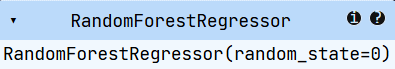

In [ ]:
mape = evaluate(rf, X_test, y_test)
pred = rf.predict(X_test)
pdf = pd.DataFrame(y_test)

pdf['pred'] = pred
pdf.plot(figsize=(20, 7))
print(f'MAPE: {mape}')

    Default 세팅이라 거의 맞추지 못하는 것을 확인할 수 있다 !

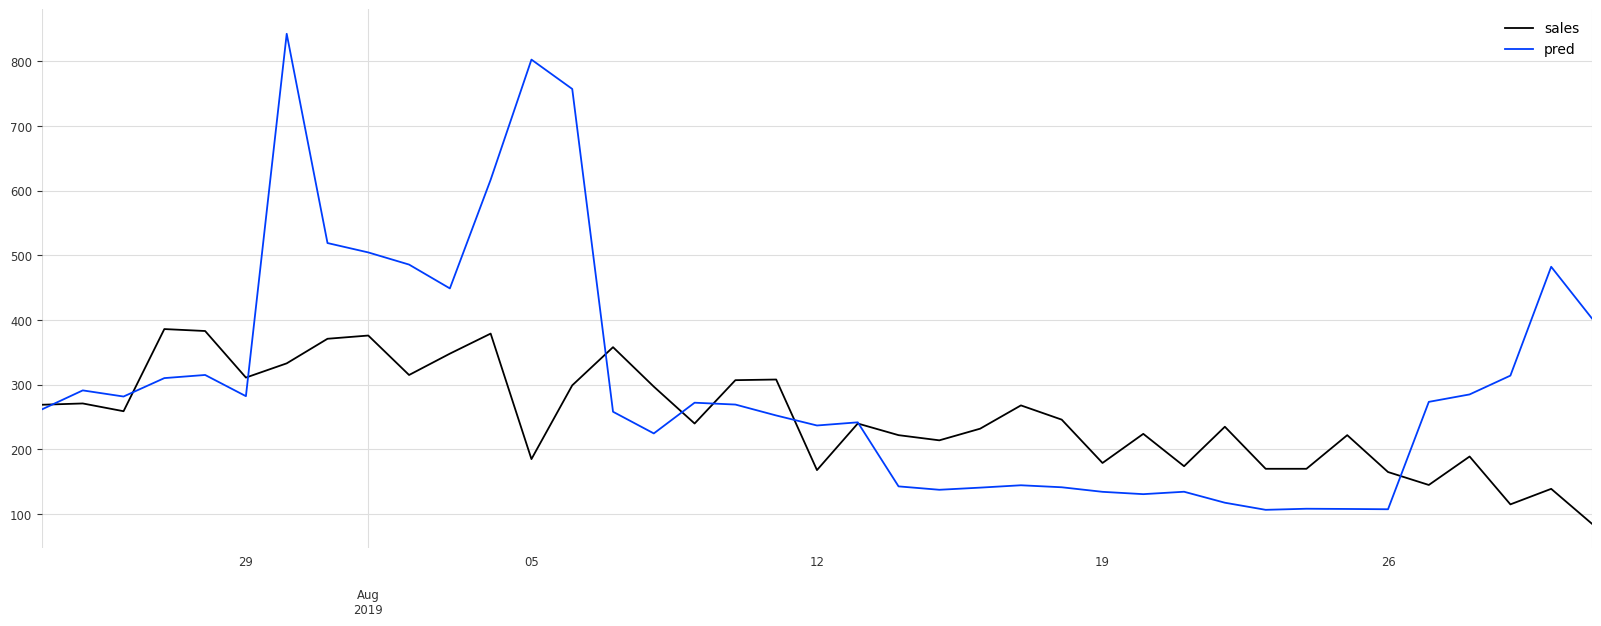



```
MAPE: 63.961299906328385
```



In [ ]:
# Under Fitting을 조정하기 위해 n_estimators와 max_features만 조정해보기
'''
n_estimators: 트리 개수(default: 100)
max_features: 트리에서 사용할 최대 피처 수; 일반적으로 max_features ≈ √(전체 피처 수) 정도가 안정적
'''
rf = RandomForestRegressor(random_state=0, n_estimators=200, max_features=4)
rf.fit(X_train, y_train)

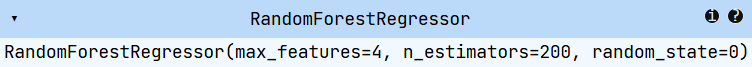

In [ ]:
mape = evaluate(rf, X_test, y_test)
pred = rf.predict(X_test)
pdf = pd.DataFrame(y_test)

pdf['pred'] = pred
pdf.plot(figsize=(20, 7))
print(f'MAPE: {mape}')

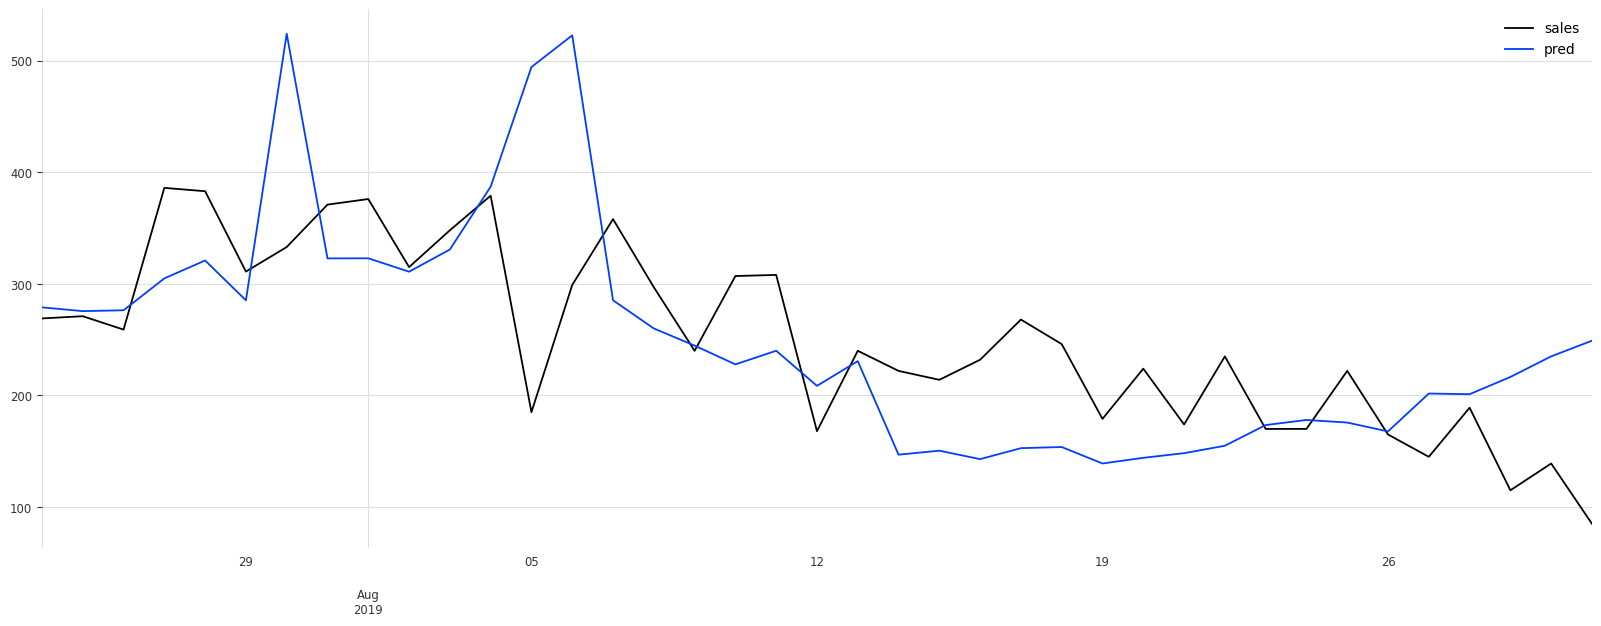



```
MAPE: 31.21643870091933
```



## 7.4. 데이터 특성에 맞는 피처를 조금 더 추가 !

In [ ]:
# 해마다 늘어나는 판매량을 반영
rdf['year'] = rdf.index.year

# 월마다 늘어나는 판매량을 반영
rdf['month'] = rdf.index.month

# 요일별 판매량 반영
rdf['weekofday'] = rdf.index.dayofweek

y = rdf['sales']
X = rdf.drop('sales', axis=1).fillna(0)
X = X[:-30]
y = y[30:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.03, random_state=0, shuffle=False)

In [ ]:
rf = RandomForestRegressor(random_state=0, n_estimators=250, max_features=4)
rf.fit(X_train, y_train)

mape = evaluate(rf, X_test, y_test)
pred = rf.predict(X_test)
pdf = pd.DataFrame(y_test)

pdf['pred'] = pred
pdf.plot(figsize=(20, 7))
print(f'MAPE: {mape}')

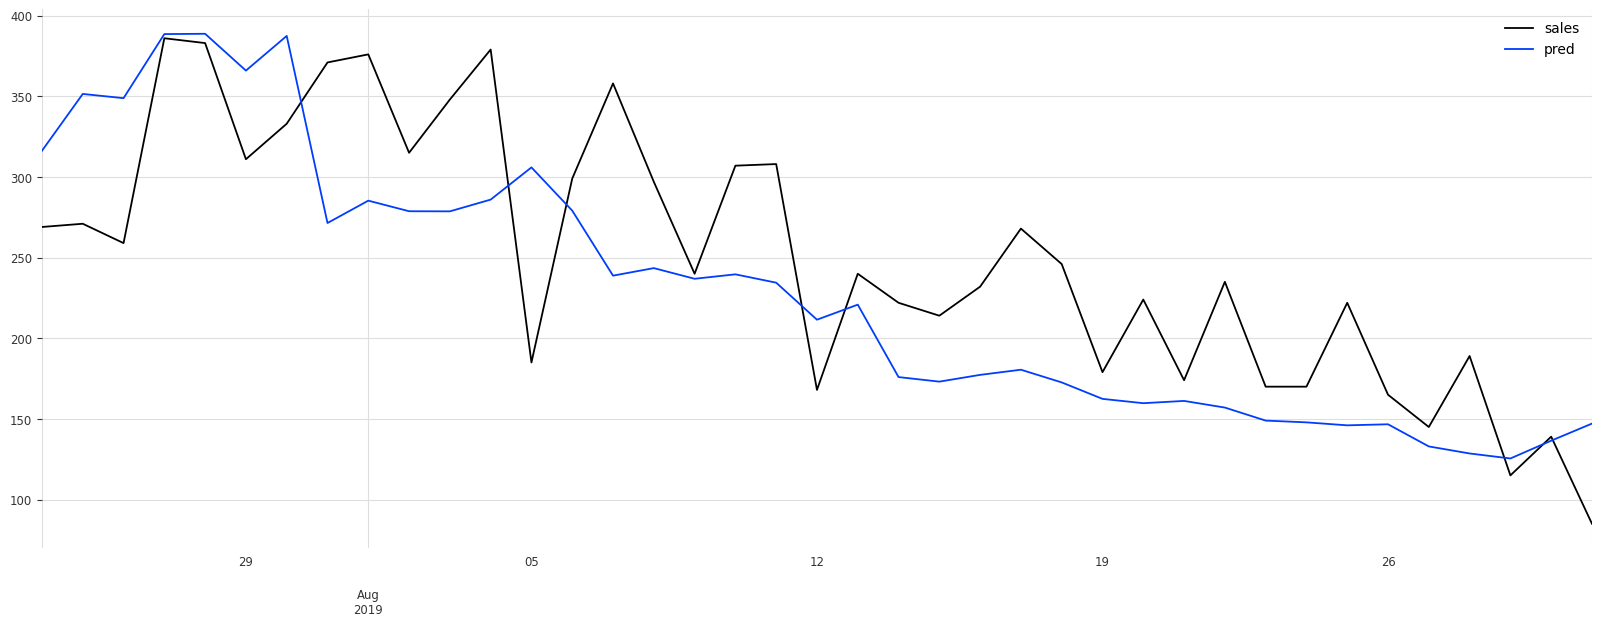

```
MAPE: 21.249467165420008
```

# 8. 결론

---

▸ 시계열 데이터 분석에서 가장 중요한 점은?

```
1. 데이터 확인이 무엇보다 중요한 분석이 시계열 분석이다.
2. 날짜형 데이터 타입을 다룰 때, 날짜 형식이 Raw 데이터에 따라 다를 수 있기 때문에 형식을 가장 먼저 확인해야 한다. (UTC/KST 등)
3. 날짜 사이에 결측이 있는지를 꼭 확인해야 하고, 결측이 있는 경우 학습이 제대로 되지 않을 수 있다.
4. RNN을 사용하는 경우, 데이터의 특성을 충분히 반영할 수 있는 하이퍼 파라미터를 세팅해줘야 한다.
```

▸ 단변량 데이터만으로는 시계열 특성이 반영되지 않는다고 판단될 때

```
1. 단변량 데이터를 특정 Window Size 기준으로 다변량 Feature를 생성해서 Regression 방식으로 바꿔볼 수도 있다.
2. 항상 더 좋은 결과를 기대할 수는 없지만, 요일별로 특성을 나타내는 경우에는 효과가 좋다.
3. 튜닝까지 할 경우 더 좋은 성능을 기대할 수 있다.
```